In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [15]:
# Load Processed Data
df = pd.read_csv('mall_customers_processed.csv')

# Double check the data
print("Data Shape:", df.shape)
df.head(10)

Data Shape: (200, 4)


,Gender,Age,Annual_Income,Spending_Score
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40
5,0,22,17,76
6,0,35,18,6
7,0,23,18,94
8,1,64,19,3
9,0,30,19,72


C:\Users\Diluksha Shamal\AppData\Local\Temp\ipykernel_16988\1808473491.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='Gender', y='Spending_Score', data=df, jitter=0.2, size=6, palette='coolwarm')


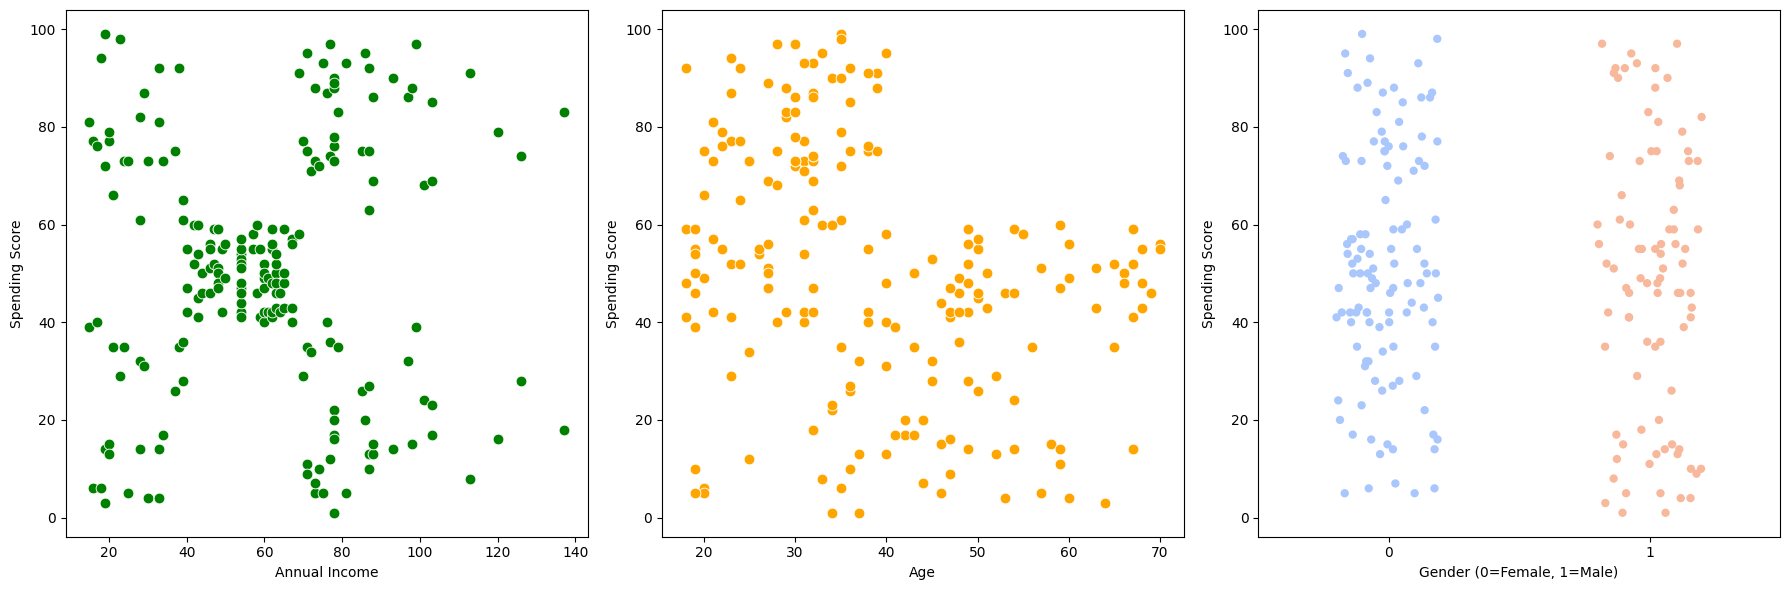

In [16]:
plt.figure(figsize=(18, 6))

# Income vs Spending
plt.subplot(1, 3, 1)
sns.scatterplot(x='Annual_Income', y='Spending_Score', data=df, s=60, color='green')
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')

# Age vs Spending
plt.subplot(1, 3, 2)
sns.scatterplot(x='Age', y='Spending_Score', data=df, s=60, color='orange')
plt.xlabel('Age')
plt.ylabel('Spending Score')

# Gender vs Spending
plt.subplot(1, 3, 3)
sns.stripplot(x='Gender', y='Spending_Score', data=df, jitter=0.2, size=6, palette='coolwarm')
plt.xlabel('Gender (0=Female, 1=Male)')
plt.ylabel('Spending Score')

plt.tight_layout()
plt.show()

In [17]:
# Select Features for Clustering
# Focus on Income and Spending Score for the "Classic" 5-cluster segmentation
X = df[['Annual_Income', 'Spending_Score']]

# View the input data
print("Input Features (X):")
print(X.head())

Input Features (X):
   Annual_Income  Spending_Score
0             15              39
1             15              81
2             16               6
3             16              77
4             17              40


In [18]:
# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Check the result (It converts to a numpy array)
print("Scaled Data (First 5 rows):")
print(X_scaled[:5])

Scaled Data (First 5 rows):
[[-1.73899919 -0.43480148]
 [-1.73899919  1.19570407]
 [-1.70082976 -1.71591298]
 [-1.70082976  1.04041783]
 [-1.66266033 -0.39597992]]


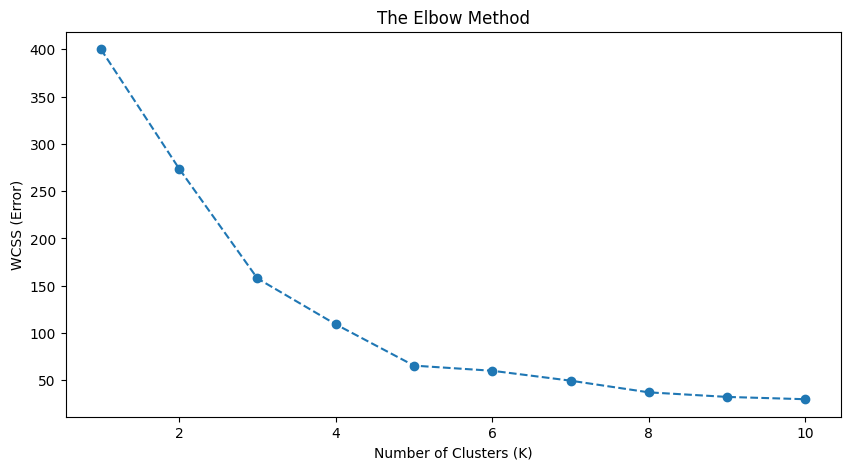

In [6]:
# Elbow Method
wcss = [] # Within-Cluster Sum of Squares (The "Error")

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Error)')
plt.show()

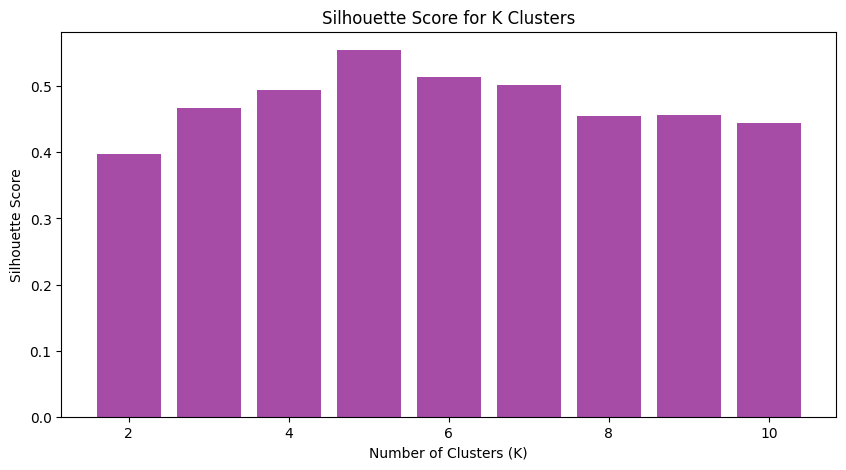

In [7]:
# Silhouette Score Validation
silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# Plot
plt.figure(figsize=(10, 5))
plt.bar(range(2, 11), silhouette_scores, color='purple', alpha=0.7)
plt.title('Silhouette Score for K Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

In [8]:
# Train Final Model with K=5
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)

# Fit and Predict
# We create a new column 'Cluster' in our original dataframe
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Check the results
print(df.head())
print("\nCluster Counts:")
print(df['Cluster'].value_counts())

   Gender  Age  Annual_Income  Spending_Score  Cluster
0       1   19             15              39        4
1       1   21             15              81        2
2       0   20             16               6        4
3       0   23             16              77        2
4       0   31             17              40        4

Cluster Counts:
Cluster
0    81
1    39
3    35
4    23
2    22
Name: count, dtype: int64


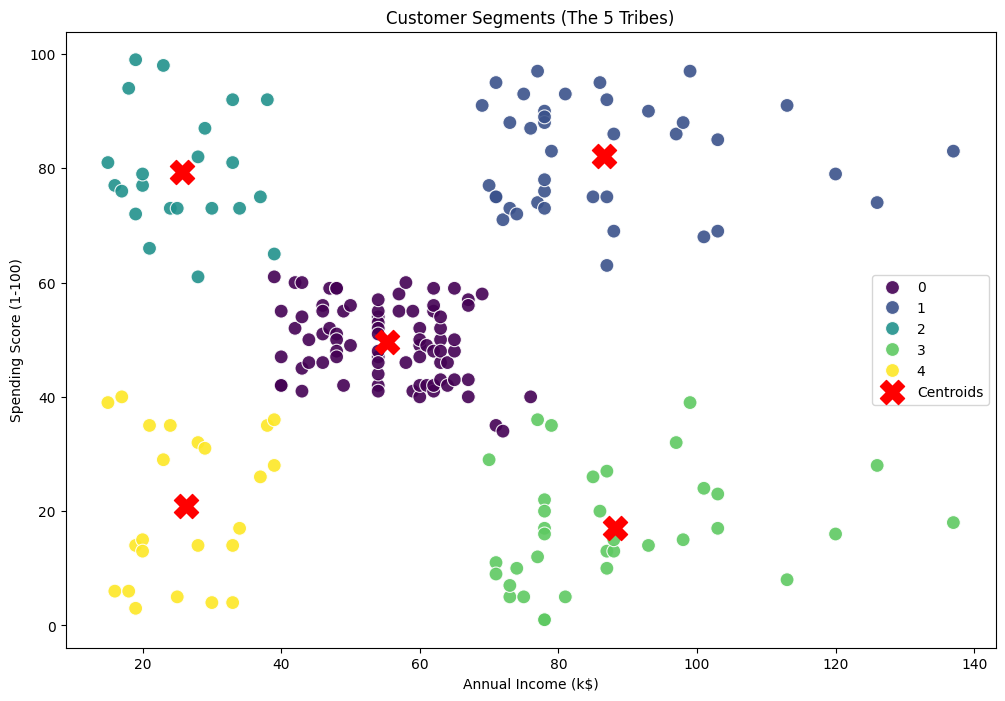

In [9]:
# Visualize the Clusters
plt.figure(figsize=(12, 8))

# Scatter plot for each cluster
sns.scatterplot(x='Annual_Income', y='Spending_Score', hue='Cluster', data=df, palette='viridis', s=100, alpha=0.9)

# Plot the Centroids (Centers)
# We need to inverse transform the centroids to get real $ values back
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='red', label='Centroids', marker='X')

plt.title('Customer Segments (The 5 Tribes)')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()

In [10]:
# Cluster Analysis
# Group by Cluster and calculate averages
cluster_summary = df.groupby('Cluster')[['Annual_Income', 'Spending_Score', 'Age']].mean()
print(cluster_summary)

         Annual_Income  Spending_Score        Age
Cluster                                          
0            55.296296       49.518519  42.716049
1            86.538462       82.128205  32.692308
2            25.727273       79.363636  25.272727
3            88.200000       17.114286  41.114286
4            26.304348       20.913043  45.217391


In [11]:
# Create a readable label map
cluster_names = {
    0: 'Average Customer',
    1: 'VIP / Whale',
    2: 'Young Trendsetter',
    3: 'High Earner Saver',
    4: 'Budget Conscious'
}

# Map the numbers to names
df['Cluster_Label'] = df['Cluster'].map(cluster_names)

# Save to CSV for the Marketing Team
df.to_csv('Marketing_Target_List.csv', index=False)
print("File 'Marketing_Target_List.csv' saved successfully.")

File 'Marketing_Target_List.csv' saved successfully.


In [12]:
def predict_customer_segment(annual_income, spending_score):
    """
    Input: Annual Income (k$), Spending Score (1-100)
    Output: The Customer Segment Name
    """
    # Create a dataframe for the single new customer
    new_data = pd.DataFrame([[annual_income, spending_score]], columns=['Annual_Income', 'Spending_Score'])
    
    # Scale the data 
    new_scaled = scaler.transform(new_data)
    
    # Predict
    cluster_id = kmeans.predict(new_scaled)[0]
    
    # Return the name
    return cluster_names[cluster_id]

# --- TEST IT ---
# Example: Someone earning $90k with a Score of 85 
print("New Customer Segment:", predict_customer_segment(90, 85))

# Example: Someone earning $30k with a Score of 80 
print("New Customer Segment:", predict_customer_segment(30, 80))

New Customer Segment: VIP / Whale
New Customer Segment: Young Trendsetter
